In [424]:
import numpy as np
import lightgbm as lgb
import enum
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import warnings
plt.style.use("dark_background")
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)


In [425]:
df = pd.read_csv('/Users/rs/Documents/white parus jun quant/volatility_task.csv')
df['ts'] = pd.to_datetime(df['ts'])

In [426]:
df['stock return'] = np.log(df['close']).diff()
df['std_60'] = df['stock return'].rolling(window=60).std()
df['mean_60'] = df['stock return'].rolling(window=60).mean()
df['std_120'] = df['stock return'].rolling(window=120).std()
df['mean_120'] = df['stock return'].rolling(window=120).mean()
df['std_360'] = df['stock return'].rolling(window=360).std()
df['mean_360'] = df['stock return'].rolling(window=360).mean()
df['std_720'] = df['stock return'].rolling(window=720).std()
df['mean_720'] = df['stock return'].rolling(window=720).mean()
df.dropna(inplace = True)
df.drop(['open', 'high', 'low'], axis=1, inplace=True)
df.head()

,ts,close,stock return,std_60,mean_60,std_120,mean_120,std_360,mean_360,std_720,mean_720
720,2023-01-01 12:00:00,16556.93,0.000016,0.000096,0.000009,0.000101,0.000009,0.000144,0.000004,0.000148,0.000001
721,2023-01-01 12:01:00,16556.27,-0.000040,0.000094,0.000010,0.000100,0.000011,0.000144,0.000003,0.000147,0.000001
722,2023-01-01 12:02:00,16558.04,0.000107,0.000095,0.000012,0.000100,0.000011,0.000144,0.000003,0.000147,0.000002
723,2023-01-01 12:03:00,16557.38,-0.000040,0.000095,0.000010,0.000100,0.000011,0.000144,0.000003,0.000147,0.000002
724,2023-01-01 12:04:00,16562.56,0.000313,0.000102,0.000017,0.000104,0.000014,0.000145,0.000004,0.000148,0.000002


## 1. Смоделируем движение цены геометрическим броуновским движением 

### Geometric Brownian Motion (GBM)

S - стоимость актива, $\mu$ - drift , $\sigma$ - volatility:
$$
\frac{\text{d}S_t}{S_t} = \mu \text{d}t + \sigma\text{d}W_t
$$
Броуновский член $\text{d}W_t $ имеет вид: 
$$
\text{d}W_t = \epsilon\sqrt{{d}t}
$$
где $\epsilon$ - нормально распределенная слечайная величина N(0,1) 

In [161]:
def cross_threshold(n_paths, n_steps, dt, S0, sigma, drift, threshold, plot = True, n_paths_plot = 25):
    paths_gbm = np.zeros((n_paths, n_steps+1))
    paths_gbm[:, 0] = S0

    for i in range(1, n_steps+1):
        dW = np.random.normal(0, 1, n_paths)*np.sqrt(dt)
        S = paths_gbm[:, i-1]
        paths_gbm[:, i] = S * (1 + drift * dt + sigma * dW)
    
    if threshold>0:
        result = np.any(paths_gbm > S0 + threshold, axis=1)
    
    else: 
        result = np.any(paths_gbm < S0 + threshold, axis=1)
        
    prob = sum(result)/len(result)
    
    if plot:
        time_arr = np.linspace(0, n_steps * dt, n_steps + 1)
        plt.figure(figsize=(20, 10))
        for i in range(n_paths_plot):
            plt.plot(time_arr, paths_gbm[i])
        plt.axhline(S0 + threshold, ls='--', label='Strike', c='darkred', linewidth=5.0)
        plt.xlabel('Time, mins')
        plt.ylabel('Price, usdt')
        plt.title('GBM price paths')
        plt.grid()
        plt.show()
        print('Вероятность пересечения границы: ', prob)
        
    return prob

установим значения параметров:

In [162]:
n_paths = 1000000
horisont = 120
dt = 1 # минута 
threshold = -300
sigma = 0.00049 # минутная
S0 = 27293
drift = 1.056e-05 # минутная

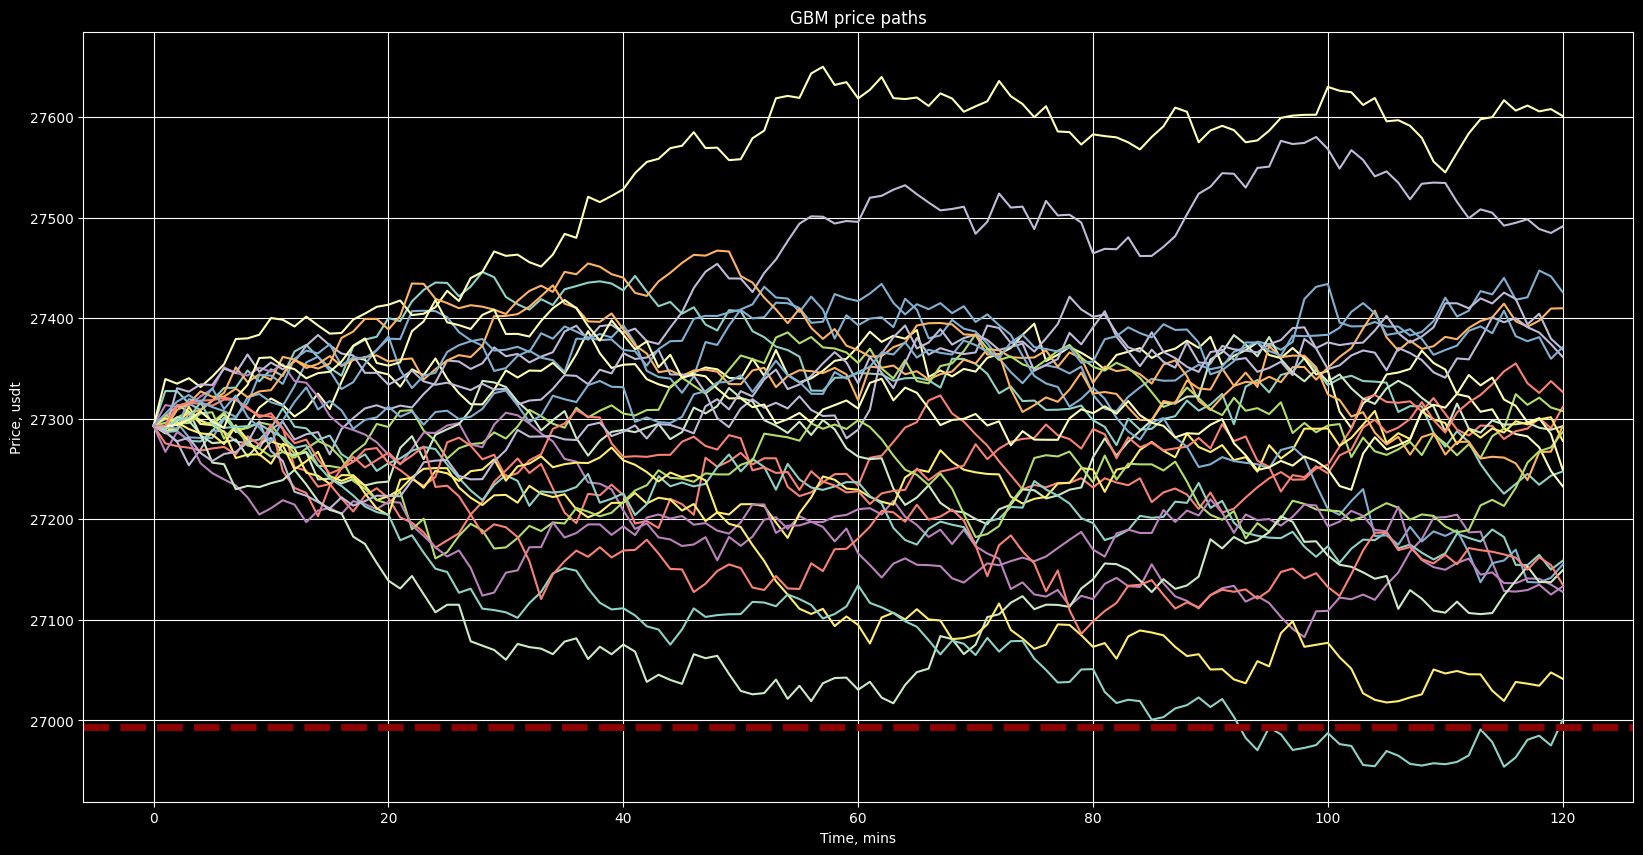

Вероятность пересечения границы:  0.020631


0.020631

In [163]:
cross_threshold(n_paths, horisont, dt, S0, sigma, drift, threshold, n_paths_plot = 25)

Теперь главным вопросом становится, какие значения минутных дрифта и волатильности выбрать для модели.

## 2. Посмотрим на минутные доходности

In [165]:
def plot_normalized_histogram(data, column_name, bins=30, xlim = 0.01):
    plt.figure(figsize=(5, 3))
    plt.hist(data[column_name], bins=bins, edgecolor='k', density=True)

    plt.title(f'Нормированная гистограмма столбца "{column_name}"', fontweight='bold')
    plt.xlabel(f'Значения "{column_name}"')
    plt.ylabel('Частота')
    plt.grid(True)
    plt.xlim(-xlim, xlim)

    plt.show()
    return data[column_name].mean(), data[column_name].std() 

def plot_close_data(df, num_points=1440):
    plt.figure(figsize=(5, 3)) 

    plt.plot(df.tail(num_points)['ts'], df.tail(num_points)['close'])  
    plt.title('График столбца close')  
    plt.xlabel('Время')  
    plt.ylabel('Значение close')  

    plt.grid(True)  
    plt.show()

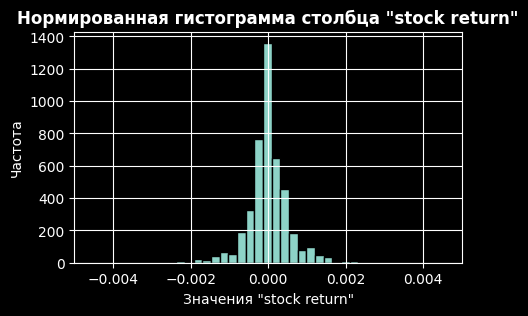

(-1.626902194160371e-06, 0.0005928331544111638)

In [166]:
plot_normalized_histogram(df.tail(720), 'stock return', bins=40 , xlim = 0.005)

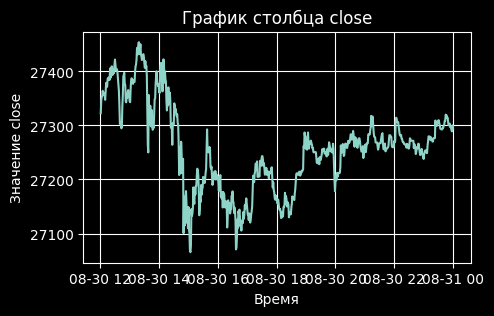

In [167]:
plot_close_data(df, num_points=720)

Видим, что сначала волатильность была относительно сильной, потом спала. Но по гистограмме мы этого не заметим.
Будем использовать значение минутной волатильности посчитанной по предистории соизмеримой с горизонтом прогноза.

In [169]:
df.head()

,ts,close,stock return,std_60,mean_60,std_120,mean_120,std_360,mean_360,std_720,mean_720
720,2023-01-01 12:00:00,16556.93,0.000016,0.000096,0.000009,0.000101,0.000009,0.000144,0.000004,0.000148,0.000001
721,2023-01-01 12:01:00,16556.27,-0.000040,0.000094,0.000010,0.000100,0.000011,0.000144,0.000003,0.000147,0.000001
722,2023-01-01 12:02:00,16558.04,0.000107,0.000095,0.000012,0.000100,0.000011,0.000144,0.000003,0.000147,0.000002
723,2023-01-01 12:03:00,16557.38,-0.000040,0.000095,0.000010,0.000100,0.000011,0.000144,0.000003,0.000147,0.000002
724,2023-01-01 12:04:00,16562.56,0.000313,0.000102,0.000017,0.000104,0.000014,0.000145,0.000004,0.000148,0.000002


Если предсказывать нужно на период 10 - 30 минут, то будем использовать std_60, mean_60 (за последние 60 минут);

Если на период 30 - 60, то будем использовать std_120, mean_120;
Если на период 60 - 90, то будем использовать std_360, mean_360;
Если на период 90 - 120, то будем использовать std_720, mean_720;

## 3. Бэктест

Разобьем данные на чанки по 60 строк (horisont): 

- по первой строке посчитаем вероятность пересечения границы на горизонте в 60 шагов (минут).

- по следующим 59 строкам посмотрим, удалось ли цене пробить границу (True/False) 

- запишем эти данные в df_res

In [250]:
chunk_size = 120
data = []
chunks = np.array_split(df.iloc[:-100000], len(df.iloc[:-100000]) / chunk_size)

In [93]:
for chunk in tqdm(chunks):
    
    n_paths = 10000
    horisont = 120
    dt = 1 
    threshold = 100
    sigma = chunk.iloc[0].std_60
    S0 = chunk.iloc[0].close
    drift = chunk.iloc[0].mean_60
    prob = cross_threshold(n_paths, horisont, dt, S0, sigma, drift, threshold, plot = False, n_paths_plot = 25)
    close_range = chunk.close.max() - chunk.close.min()    
    if threshold > 0:
        data.append([chunk.iloc[0].ts, chunk.iloc[0].close,\
                 chunk.iloc[0].mean_60, chunk.iloc[0].std_60,\
                 close_range, threshold, horisont,\
                 prob, np.any(chunk.close > S0 + threshold)])
    else:
        data.append([chunk.iloc[0].ts, chunk.iloc[0].close,\
                 chunk.iloc[0].mean_60, chunk.iloc[0].std_60,\
                 close_range, threshold, horisont,\
                 prob, np.any(chunk.close < S0 + threshold)])


100%|███████████████████████████████████████| 5794/5794 [03:04<00:00, 31.45it/s]


In [94]:
df_res = pd.DataFrame(data, columns=['ts', 'close', 'mean', 'std', 'close_range', 'threshold', 'horisont', 'probability', 'result'])

- Из всех данных выберем те, где предсказанная вероятность лежит в пределах [a, b] 
- Посчитаем в скольких из этих данным цена действительно пробила границу.

In [109]:
df_sliced = df_res[(df_res['probability'] >= 0) & (df_res['probability'] <= 0.01)]
p0 = df_sliced['result'].sum()/len(df_sliced['result'])

In [110]:
df_sliced = df_res[(df_res['probability'] >= 0.01) & (df_res['probability'] <= 0.1)]
p1 = df_sliced['result'].sum()/len(df_sliced['result'])

In [96]:
df_sliced = df_res[(df_res['probability'] >= 0) & (df_res['probability'] <= 0.1)]
p1 = df_sliced['result'].sum()/len(df_sliced['result'])

In [97]:
df_sliced = df_res[(df_res['probability'] >= 0.1) & (df_res['probability'] <= 0.2)]
p2 = df_sliced['result'].sum()/len(df_sliced['result'])

In [98]:
df_sliced = df_res[(df_res['probability'] >= 0.2) & (df_res['probability'] <= 0.3)]
p3 = df_sliced['result'].sum()/len(df_sliced['result'])

In [99]:
df_sliced = df_res[(df_res['probability'] >= 0.3) & (df_res['probability'] <= 0.4)]
p4 = df_sliced['result'].sum()/len(df_sliced['result'])

In [100]:
df_sliced = df_res[(df_res['probability'] >= 0.4) & (df_res['probability'] <= 0.5)]
p5 = df_sliced['result'].sum()/len(df_sliced['result'])

In [101]:
df_sliced = df_res[(df_res['probability'] >= 0.5) & (df_res['probability'] <= 0.6)]
p6 = df_sliced['result'].sum()/len(df_sliced['result'])

In [102]:
df_sliced = df_res[(df_res['probability'] >= 0.6) & (df_res['probability'] <= 0.7)]
p7 = df_sliced['result'].sum()/len(df_sliced['result'])

In [103]:
df_sliced = df_res[(df_res['probability'] >= 0.7) & (df_res['probability'] <= 0.8)]
p8 = df_sliced['result'].sum()/len(df_sliced['result'])

In [104]:
df_sliced = df_res[(df_res['probability'] >= 0.8) & (df_res['probability'] <= 0.9)]
p9 = df_sliced['result'].sum()/len(df_sliced['result'])

In [105]:
df_sliced = df_res[(df_res['probability'] >= 0.9) & (df_res['probability'] <= 1.0)]
p10 = df_sliced['result'].sum()/len(df_sliced['result'])

In [135]:
bins = [0, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
labels = [0, 0, p2, p3, p4, p5, p6, p7, p8, np.nan, np.nan] 
df_res['res_prob'] = pd.cut(df_res['probability'], bins=bins, labels=labels, right=False, ordered=False)


In [480]:
def chunk_back_test(df_orig, threshold, horisont=60):
    df = df_orig.copy()
    data = []
    dt=1
    n_paths=10000
    chunk_size=horisont
    chunks = np.array_split(df, len(df) / chunk_size)

    for chunk in tqdm(chunks):
        if 10 <= horisont <= 30:
            sigma = chunk.iloc[0].std_60
            drift = chunk.iloc[0].mean_60
        elif 30 < horisont <= 60:
            sigma = chunk.iloc[0].std_120
            drift = chunk.iloc[0].mean_120
        elif 60 < horisont <= 90:
            sigma = chunk.iloc[0].std_360
            drift = chunk.iloc[0].mean_360
        elif 90 < horisont <= 120:
            sigma = chunk.iloc[0].std_720
            drift = chunk.iloc[0].mean_720
        else:
            raise ValueError("Недопустимое значение horisont")
            
        S0 = chunk.iloc[0].close
        prob = cross_threshold(n_paths, horisont, dt, S0, sigma, drift, threshold, plot=False, n_paths_plot=25)
        close_range = chunk.close.max() - chunk.close.min()    

        if threshold > 0:
            data.append([chunk.iloc[0].ts, chunk.iloc[0].close,\
                     chunk.iloc[0].mean_60, chunk.iloc[0].std_60,\
                     chunk.close.max(), chunk.close.max(),\
                     close_range, threshold, horisont,\
                     prob, np.any(chunk.close > S0 + threshold)])
        else:
            data.append([chunk.iloc[0].ts, chunk.iloc[0].close,\
                     chunk.iloc[0].mean_60, chunk.iloc[0].std_60,\
                     chunk.close.max(), chunk.close.max(),\
                     close_range, threshold, horisont,\
                     prob, np.any(chunk.close < S0 + threshold)])


    df_res = pd.DataFrame(data, columns=['ts', 'close', 'mean', 'std', 'close_max', 'close_min',\
                                         'close_range', 'threshold',\
                                         'horisont', 'probability', 'result'])
    
    probability_ranges = [(0, 0.01), (0.01, 0.1), (0.1, 0.2), (0.2, 0.3), (0.3, 0.4), (0.4, 0.5),\
                          (0.5, 0.6), (0.6, 0.7), (0.7, 0.8), (0.8, 0.9), (0.9, 1.0)]
    res_prob = []
    for range_start, range_end in probability_ranges:
        df_sliced = df_res[(df_res['probability'] >= range_start) & (df_res['probability'] <= range_end)]
        result = df_sliced['result'].sum() / len(df_sliced['result'])
        res_prob.append(result)
        #print(f"Для диапазона [{range_start}, {range_end}]: {result}")


    conditions = [
        (df_res['probability'] >= 0) & (df_res['probability'] < 0.01),
        (df_res['probability'] >= 0.01) & (df_res['probability'] < 0.1),
        (df_res['probability'] >= 0.1) & (df_res['probability'] < 0.2),
        (df_res['probability'] >= 0.2) & (df_res['probability'] < 0.3),
        (df_res['probability'] >= 0.3) & (df_res['probability'] < 0.4),
        (df_res['probability'] >= 0.4) & (df_res['probability'] < 0.5),
        (df_res['probability'] >= 0.5) & (df_res['probability'] < 0.6),
        (df_res['probability'] >= 0.6) & (df_res['probability'] < 0.7),
        (df_res['probability'] >= 0.7) & (df_res['probability'] < 0.8),
        (df_res['probability'] >= 0.8) & (df_res['probability'] < 0.9),
        (df_res['probability'] >= 0.9) & (df_res['probability'] < 1),
    ]


    df_res['res_prob'] = np.select(conditions, res_prob, default=-1)
    
    df_res = pd.merge_asof(df_res, df.drop(columns=['close']), on='ts', direction='backward')
    df_res.dropna(inplace=True)
    
    return df_res

In [354]:
df_wer = chunk_back_test(df.iloc[:-100000], threshold=-100, horisont=100)

100%|███████████████████████████████████████| 2476/2476 [02:17<00:00, 18.06it/s]

Для диапазона [0, 0.01]: 0.011627906976744186
Для диапазона [0.01, 0.1]: 0.09876543209876543
Для диапазона [0.1, 0.2]: 0.19004524886877827
Для диапазона [0.2, 0.3]: 0.2459546925566343
Для диапазона [0.3, 0.4]: 0.26046511627906976
Для диапазона [0.4, 0.5]: 0.3758099352051836
Для диапазона [0.5, 0.6]: 0.34560906515580736
Для диапазона [0.6, 0.7]: 0.4296028880866426
Для диапазона [0.7, 0.8]: 0.40298507462686567
Для диапазона [0.8, 0.9]: 0.37209302325581395
Для диапазона [0.9, 1.0]: nan


Записали все шаги описанные выше в одну функцию.


## 4. Добавим ML для улучшения точности прогноза вероятности 

### Создадим train_df - используя все кроме последних 100000 строк данных.

In [357]:
threshold_values = list(range(-400, 401, 100))
horisont_values = list(range(20, 121, 20))

dfs = []

for threshold in threshold_values:
    for horisont in horisont_values:
        df_name = f'df_{threshold}_{horisont}'
        print(df_name)
        df_name = chunk_back_test(df.iloc[:-100000], threshold=threshold, horisont=horisont) 
        dfs.append(df_name)



df_-400_20


100%|█████████████████████████████████████| 12384/12384 [02:39<00:00, 77.54it/s]


df_-400_40


100%|███████████████████████████████████████| 6192/6192 [02:18<00:00, 44.85it/s]


df_-400_60


100%|███████████████████████████████████████| 4128/4128 [02:14<00:00, 30.67it/s]


df_-400_80


100%|███████████████████████████████████████| 3096/3096 [02:06<00:00, 24.39it/s]


df_-400_100


100%|███████████████████████████████████████| 2476/2476 [02:03<00:00, 20.07it/s]


df_-400_120


100%|███████████████████████████████████████| 2064/2064 [02:04<00:00, 16.57it/s]


df_-300_20


100%|█████████████████████████████████████| 12384/12384 [02:38<00:00, 78.30it/s]


df_-300_40


100%|███████████████████████████████████████| 6192/6192 [02:16<00:00, 45.31it/s]


df_-300_60


100%|███████████████████████████████████████| 4128/4128 [02:12<00:00, 31.22it/s]


df_-300_80


100%|███████████████████████████████████████| 3096/3096 [02:09<00:00, 23.99it/s]


df_-300_100


100%|███████████████████████████████████████| 2476/2476 [02:07<00:00, 19.44it/s]


df_-300_120


100%|███████████████████████████████████████| 2064/2064 [02:20<00:00, 14.71it/s]


df_-200_20


100%|█████████████████████████████████████| 12384/12384 [02:43<00:00, 75.69it/s]


df_-200_40


100%|███████████████████████████████████████| 6192/6192 [02:21<00:00, 43.83it/s]


df_-200_60


100%|███████████████████████████████████████| 4128/4128 [02:18<00:00, 29.72it/s]


df_-200_80


100%|███████████████████████████████████████| 3096/3096 [02:22<00:00, 21.74it/s]


df_-200_100


100%|███████████████████████████████████████| 2476/2476 [02:18<00:00, 17.91it/s]


df_-200_120


100%|███████████████████████████████████████| 2064/2064 [02:15<00:00, 15.22it/s]


df_-100_20


100%|█████████████████████████████████████| 12384/12384 [02:49<00:00, 72.95it/s]


df_-100_40


100%|███████████████████████████████████████| 6192/6192 [02:16<00:00, 45.42it/s]


df_-100_60


100%|███████████████████████████████████████| 4128/4128 [02:16<00:00, 30.29it/s]


df_-100_80


100%|███████████████████████████████████████| 3096/3096 [02:06<00:00, 24.50it/s]


df_-100_100


100%|███████████████████████████████████████| 2476/2476 [02:03<00:00, 20.05it/s]


df_-100_120


100%|███████████████████████████████████████| 2064/2064 [02:07<00:00, 16.13it/s]


df_0_20


100%|█████████████████████████████████████| 12384/12384 [02:36<00:00, 78.92it/s]


df_0_40


100%|███████████████████████████████████████| 6192/6192 [02:13<00:00, 46.25it/s]


df_0_60


100%|███████████████████████████████████████| 4128/4128 [02:19<00:00, 29.62it/s]


df_0_80


100%|███████████████████████████████████████| 3096/3096 [02:10<00:00, 23.79it/s]


df_0_100


100%|███████████████████████████████████████| 2476/2476 [02:04<00:00, 19.85it/s]


df_0_120


100%|███████████████████████████████████████| 2064/2064 [02:03<00:00, 16.73it/s]


df_100_20


100%|█████████████████████████████████████| 12384/12384 [02:42<00:00, 76.30it/s]


df_100_40


100%|███████████████████████████████████████| 6192/6192 [02:14<00:00, 46.05it/s]


df_100_60


100%|███████████████████████████████████████| 4128/4128 [02:17<00:00, 30.12it/s]


df_100_80


100%|███████████████████████████████████████| 3096/3096 [02:06<00:00, 24.43it/s]


df_100_100


100%|███████████████████████████████████████| 2476/2476 [02:07<00:00, 19.37it/s]


df_100_120


100%|███████████████████████████████████████| 2064/2064 [02:10<00:00, 15.79it/s]


df_200_20


100%|█████████████████████████████████████| 12384/12384 [02:39<00:00, 77.56it/s]


df_200_40


100%|███████████████████████████████████████| 6192/6192 [02:19<00:00, 44.50it/s]


df_200_60


100%|███████████████████████████████████████| 4128/4128 [02:10<00:00, 31.67it/s]


df_200_80


100%|███████████████████████████████████████| 3096/3096 [02:13<00:00, 23.22it/s]


df_200_100


100%|███████████████████████████████████████| 2476/2476 [02:03<00:00, 20.03it/s]


df_200_120


100%|███████████████████████████████████████| 2064/2064 [02:10<00:00, 15.81it/s]


df_300_20


100%|█████████████████████████████████████| 12384/12384 [02:31<00:00, 81.98it/s]


df_300_40


100%|███████████████████████████████████████| 6192/6192 [02:11<00:00, 47.20it/s]


df_300_60


100%|███████████████████████████████████████| 4128/4128 [02:16<00:00, 30.19it/s]


df_300_80


100%|███████████████████████████████████████| 3096/3096 [02:05<00:00, 24.73it/s]


df_300_100


100%|███████████████████████████████████████| 2476/2476 [02:01<00:00, 20.41it/s]


df_300_120


100%|███████████████████████████████████████| 2064/2064 [02:07<00:00, 16.13it/s]


df_400_20


100%|█████████████████████████████████████| 12384/12384 [02:32<00:00, 81.24it/s]


df_400_40


100%|███████████████████████████████████████| 6192/6192 [02:13<00:00, 46.54it/s]


df_400_60


100%|███████████████████████████████████████| 4128/4128 [02:17<00:00, 29.93it/s]


df_400_80


100%|███████████████████████████████████████| 3096/3096 [02:05<00:00, 24.69it/s]


df_400_100


100%|███████████████████████████████████████| 2476/2476 [02:01<00:00, 20.43it/s]


df_400_120


100%|███████████████████████████████████████| 2064/2064 [02:02<00:00, 16.88it/s]


In [360]:
df_train = pd.concat(dfs, axis=0)

In [442]:
df_train.head(2)

,ts,close,mean,std,close_max,close_min,close_range,threshold,horisont,probability,result,res_prob,stock_return,std_60,mean_60,std_120,mean_120,std_360,mean_360,std_720,mean_720
0,2023-01-01 12:00:00,16556.93,0.000009,0.000096,16567.80,16567.80,15.92,-400,20,0.0,False,0.002174,0.000016,0.000096,0.000009,0.000101,0.000009,0.000144,0.000004,0.000148,0.000001
1,2023-01-01 12:21:00,16559.18,0.000015,0.000131,16571.27,16571.27,15.02,-400,20,0.0,False,0.002174,-0.000120,0.000131,0.000015,0.000120,0.000009,0.000146,0.000003,0.000148,0.000002


 ## Обучение модели

In [470]:
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

def train_lgb_regression(df, params, num_folds=5):
    df.columns = df.columns.str.replace(' ', '_')
    features = [col for col in df.columns if col not in {"ts", "result", 'res_prob'}]
    target = 'res_prob'
    X = df[features]
    y = df[target]
   
    
    X_val = X.tail(50000).head(25000)
    y_val = y.tail(50000).head(25000)
    
    X_test = X.head(25000)
    y_test = y.head(25000)
    

    X_train = X[:-50000]
    y_train = y[:-50000]

    train_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)
    test_data = lgb.Dataset(X_test, y_test)

    model = lgb.train(
        params=params,
        num_boost_round=500,
        train_set=train_data,
        valid_sets=[train_data, test_data, val_data],
        valid_names=('tr', 'test', 'val'),
        early_stopping_rounds=5,
        callbacks=[lgb.log_evaluation(50)]
    )
    print('model.best_iteration', model.best_iteration)
    y_pred = model.predict(X_test, num_iteration=model.best_iteration)

    print(f'Mean RMSE: {mean_rmse}')
    lgb.plot_importance(model, max_num_features=20)
    
    return model



[50]	tr's rmse: 0.0274565	test's rmse: 0.0199982	val's rmse: 0.0289304
[100]	tr's rmse: 0.0116416	test's rmse: 0.00909668	val's rmse: 0.0214989
model.best_iteration 116
Mean RMSE: 0.011316595816417361


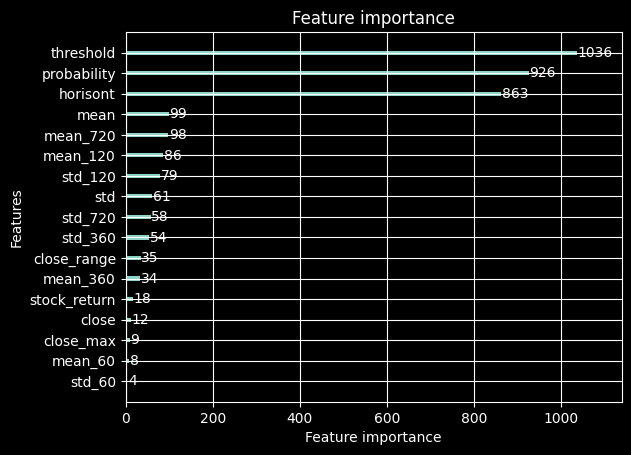

In [471]:
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0,
    'force_row_wise': True
}

model = train_lgb_regression(df_train, params)

## Бэктест 

In [512]:
df_test = df.tail(100000)

In [513]:
def print_res_prob(df_res, col_name='probability'):
    probability_ranges = [(0, 0.01), (0.01, 0.1), (0.1, 0.2), (0.2, 0.3), (0.3, 0.4), (0.4, 0.5),
                          (0.5, 0.6), (0.6, 0.7), (0.7, 0.8), (0.8, 0.9), (0.9, 1.0)]
    res_prob = []
    
    for range_start, range_end in probability_ranges:
        df_sliced = df_res[(df_res[col_name] >= range_start) & (df_res[col_name] <= range_end)]
        result = df_sliced['result'].sum() / len(df_sliced['result'])
        res_prob.append(result)
        print(f"Для диапазона [{range_start}, {range_end}]: {result}")



In [542]:
def predict_and_print_res_prob(df_test, model, threshold=100, horisont=60):
    if df_test.shape[0] < horisont:
        raise ValueError("Длина df_test должна быть больше horisont прогноза.")
    
    df_test_res = chunk_back_test(df_test, threshold=threshold, horisont=horisont) 
    features = [col for col in df_test_res.columns if col not in {"ts", "result", 'res_prob'}]
    target = 'res_prob'
    X_test = df_test_res[features]
    y_test = df_test_res[target]
    df_test_res['prob_GBM_and_LGB'] = model.predict(X_test)
    print_res_prob(df_test_res, col_name='prob_GBM_and_LGB')


In [560]:
predict_and_print_res_prob(df_test, model, threshold=50, horisont=100)

100%|███████████████████████████████████████| 1000/1000 [00:53<00:00, 18.66it/s]


Для диапазона [0, 0.01]: nan
Для диапазона [0.01, 0.1]: 0.058823529411764705
Для диапазона [0.1, 0.2]: 0.14814814814814814
Для диапазона [0.2, 0.3]: 0.375886524822695
Для диапазона [0.3, 0.4]: 0.40236686390532544
Для диапазона [0.4, 0.5]: 0.526595744680851
Для диапазона [0.5, 0.6]: 0.5531914893617021
Для диапазона [0.6, 0.7]: nan
Для диапазона [0.7, 0.8]: nan
Для диапазона [0.8, 0.9]: nan
Для диапазона [0.9, 1.0]: nan


### Описание полученных результатов
- df_test разбивается на 1000 промежутков по 100 минут
- считается вероятност по 1 строке и проверяется по следующим 99 строкам произошел ли пробив границы (True/False)
- видим что посчитанные вероятности (в зависимости от дрифта и волатильности) - считаются в пределах от 0.01 до 0.6 для введенных threshold=50, horisont=100.
- если модель предсказывает вероятность [0.1, 0.2], то среди этих строк - пробив границы происходим в 0.148 случаях из всех (назовем это true_probability) - аналогично по остальным промежуткам
- значения nan означают что таких вероятностей предсказано не было для этих данных.
- видим что после добавления LGB в модель - значения true_probability лучше попадают в диапазон предсказанной вероятности.

In [561]:
predict_and_print_res_prob(df_test.tail(60), model, threshold=100, horisont=60)

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.48it/s]

Для диапазона [0, 0.01]: nan
Для диапазона [0.01, 0.1]: nan
Для диапазона [0.1, 0.2]: 0.0
Для диапазона [0.2, 0.3]: nan
Для диапазона [0.3, 0.4]: nan
Для диапазона [0.4, 0.5]: nan
Для диапазона [0.5, 0.6]: nan
Для диапазона [0.6, 0.7]: nan
Для диапазона [0.7, 0.8]: nan
Для диапазона [0.8, 0.9]: nan
Для диапазона [0.9, 1.0]: nan


- если мы ходим посчитать разовый прогноз, по подадим на вход срез равный горизонту прогноза
- видим что вероятность лежит в пределах [0.1, 0.2], значение 0 указывает, что граница не пересечена

In [515]:
predict_and_print_res_prob(df_test, model, threshold=100, horisont=60)

100%|███████████████████████████████████████| 1666/1666 [00:54<00:00, 30.56it/s]

Для диапазона [0, 0.01]: nan
Для диапазона [0.01, 0.1]: 0.04296875
Для диапазона [0.1, 0.2]: 0.12792792792792793
Для диапазона [0.2, 0.3]: 0.20772946859903382
Для диапазона [0.3, 0.4]: 0.30612244897959184
Для диапазона [0.4, 0.5]: 0.36666666666666664
Для диапазона [0.5, 0.6]: 0.75
Для диапазона [0.6, 0.7]: nan
Для диапазона [0.7, 0.8]: nan
Для диапазона [0.8, 0.9]: nan
Для диапазона [0.9, 1.0]: nan


In [516]:
predict_and_print_res_prob(df_test, model, threshold=-100, horisont=100)

100%|███████████████████████████████████████| 1000/1000 [00:53<00:00, 18.53it/s]

Для диапазона [0, 0.01]: nan
Для диапазона [0.01, 0.1]: 0.06289308176100629
Для диапазона [0.1, 0.2]: 0.16
Для диапазона [0.2, 0.3]: 0.19402985074626866
Для диапазона [0.3, 0.4]: 0.31716417910447764
Для диапазона [0.4, 0.5]: 0.3625
Для диапазона [0.5, 0.6]: nan
Для диапазона [0.6, 0.7]: nan
Для диапазона [0.7, 0.8]: nan
Для диапазона [0.8, 0.9]: nan
Для диапазона [0.9, 1.0]: nan


In [517]:
predict_and_print_res_prob(df_test, model, threshold=50, horisont=100)

100%|███████████████████████████████████████| 1000/1000 [00:54<00:00, 18.40it/s]


Для диапазона [0, 0.01]: nan
Для диапазона [0.01, 0.1]: 0.058823529411764705
Для диапазона [0.1, 0.2]: 0.14814814814814814
Для диапазона [0.2, 0.3]: 0.36764705882352944
Для диапазона [0.3, 0.4]: 0.40058479532163743
Для диапазона [0.4, 0.5]: 0.5289473684210526
Для диапазона [0.5, 0.6]: 0.5681818181818182
Для диапазона [0.6, 0.7]: nan
Для диапазона [0.7, 0.8]: nan
Для диапазона [0.8, 0.9]: nan
Для диапазона [0.9, 1.0]: nan


In [518]:
predict_and_print_res_prob(df_test, model, threshold=500, horisont=100)

100%|███████████████████████████████████████| 1000/1000 [00:51<00:00, 19.42it/s]


Для диапазона [0, 0.01]: nan
Для диапазона [0.01, 0.1]: 0.005070993914807302
Для диапазона [0.1, 0.2]: 0.07142857142857142
Для диапазона [0.2, 0.3]: nan
Для диапазона [0.3, 0.4]: nan
Для диапазона [0.4, 0.5]: nan
Для диапазона [0.5, 0.6]: nan
Для диапазона [0.6, 0.7]: nan
Для диапазона [0.7, 0.8]: nan
Для диапазона [0.8, 0.9]: nan
Для диапазона [0.9, 1.0]: nan


In [554]:
predict_and_print_res_prob(df_test.tail(300), model, threshold=50, horisont=100)

100%|█████████████████████████████████████████████| 3/3 [00:00<00:00, 13.54it/s]

Для диапазона [0, 0.01]: nan
Для диапазона [0.01, 0.1]: nan
Для диапазона [0.1, 0.2]: nan
Для диапазона [0.2, 0.3]: nan
Для диапазона [0.3, 0.4]: nan
Для диапазона [0.4, 0.5]: 0.3333333333333333
Для диапазона [0.5, 0.6]: nan
Для диапазона [0.6, 0.7]: nan
Для диапазона [0.7, 0.8]: nan
Для диапазона [0.8, 0.9]: nan
Для диапазона [0.9, 1.0]: nan
